# option de vente amèricaine

In [374]:
import numpy as np
import copy
import time

## Chaînage arrière 

In [419]:
#choisir le nombre de période ici
### Pour la petite instance choisir N=3
### Pour la moyenne instance choisir N=100
### Pour la grande instance choisir N=1000
N=1000

In [420]:
t1=time.time()
#donnés initiales du problème
x0=50   #prix de l'action à l'achat du titre
K=50    # prix d'exercice de l'option
r=0.01   #taux sans risque
u=1.1    #rendement à la hausse du prix de l'action

d=1/u    #rendement à la baisse du prix de l'action
p=(1+r-d)/(u-d)    #probabilité risque-neutre

# initialisation des dictionnaires des états, de la fonction ojective et de l'espace des actions
X={}
J={}   
U={}

#différentes valeur pour t=N pour les différentes valeur du prix de l'action possible
X[N]=np.zeros(N+1)
J[N]=np.zeros(N+1)
U[N]=np.zeros(N+1)
for s in range(N+1): #s est le nombre de fois où l'action augmente
    X[N][s]=u**s*d**(N-s)*x0
    J[N][s]=np.where(K-u**s*d**(N-s)*x0<=0,J[N][s],K-u**s*d**(N-s)*x0)
    U[N][s]=np.where(K-u**s*d**(N-s)*x0<=0,U[N][s],1)
    
#boucle pour les différentes valeur de k
for k in range(N-1,0-1,-1):
    X[k]=np.zeros(k+1)
    J[k]=np.zeros(k+1)
    U[k]=np.zeros(k+1)
    for s in range(k+1):
        X[k][s]=u**s*d**(k-s)*x0
        condition=(K-u**s*d**(k-s)*x0)<=(p*J[k+1][s+1]+(1-p)*J[k+1][s])/(1+r)   # profit possible qu temps k < moyenne des profits futures
        J[k][s]=np.where(condition,J[k][s],K-u**s*d**(k-s)*x0)
        J[k][s]=np.where(not condition,J[k][s],(p*J[k+1][s+1]+(1-p)*J[k+1][s])/(1+r))
        U[k][s]=np.where(condition,U[k][s],1)
        
#calcul des valeurs seuils                               
alpha=[]
for i in range(N,-1,-1):
    #print(i)
    JplusX=J[i]+X[i]
    alpha.append(np.amax(np.where(JplusX == K, X[i], 0)))
alpha=alpha[::-1]

# Affichage des valeurs
#print("prix de l'action de "+str(N)+" à 0: ")
#print(X)
#print("")
#print( "profit pour k de "+str(N)+" à 0: ")
#print(J)
#print("")
#print( "action: 0 si on exerce l'option et 1 si attend avant de l'exercer pour k de "+str(N)+" à 0:")
#print(U)
#print("")
print("profit espéré de l'option au temps 0 : ",J[0][0])
print("")
print("les seuils pour k de 0 à "+str(N)+" : ")
print(alpha)
t2=time.time()
laps=t2-t1
print("laps=",laps)


profit espéré de l'option au temps 0 :  6.849974093015026

les seuils pour k de 0 à 1000 : 
[0.0, 0.0, 0.0, 0.0, 34.15067276825353, 31.046066152957753, 34.15067276825353, 31.046066152957756, 34.15067276825353, 31.046066152957756, 34.150672768253536, 31.046066152957764, 34.150672768253536, 31.046066152957756, 34.150672768253536, 31.046066152957764, 34.15067276825354, 31.046066152957764, 34.15067276825354, 31.046066152957764, 34.15067276825354, 31.046066152957767, 34.15067276825355, 31.046066152957767, 34.15067276825355, 31.046066152957767, 34.15067276825355, 31.046066152957767, 34.15067276825355, 31.046066152957767, 34.15067276825356, 31.046066152957774, 34.15067276825356, 31.046066152957774, 34.15067276825356, 31.046066152957774, 34.15067276825356, 31.046066152957774, 34.15067276825356, 31.046066152957785, 34.15067276825356, 31.04606615295778, 34.15067276825356, 31.04606615295778, 34.15067276825356, 31.04606615295778, 34.15067276825356, 31.046066152957785, 34.15067276825357, 31.0460661

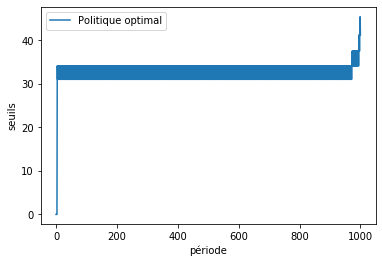

In [421]:
#affichage des seuils(politique optimale)
import matplotlib.pylab as plt
plt.plot(alpha)
plt.legend(['Politique optimal'])
plt.ylabel('seuils')
plt.xlabel('période')
plt.show()

## simulation  et approximation paramétrique

In [422]:
def approx(N,x0,u,r,K,q):
    #simulation de q trajectoire de prix sur N étapes
    d=1/u
    p=(1+r-d)/(u-d) 
    z=1/(1+r)
    X_tilde=np.ones((q,N+1))*x0
    for i in range(q):
        for k in range(1,N+1):
            X_tilde[i,k:]=np.where(np.random.binomial(1,p,1)==1,X_tilde[i,k:]*u*z,X_tilde[i,k:]*d*z)
    # Construction de la matrice des cash-flow
    CF=np.where(K-X_tilde[:,1:] > 0, K-X_tilde[:,1:], 0)   #valeur d'exercice moins la valeur de x si positif et 0 sinon

    #Actulisation de la matrice des cash-flow
    for k in range(N-1,0,-1):

        ### Régression pour déterminer le profit espéré au temps k
        x=np.extract(X_tilde[:,k] < K, X_tilde[:,k])
        y=np.extract(X_tilde[:,k] < K,CF[:,k] )
        #y=y*z
        R=np.polyfit(x,y,2)
        Jkplus1_tilde= R[0]*X_tilde[:,k]**2 +R[1]*X_tilde[:,k] + R[2]

        ### Décision optimal entre exercer l'option ou attendre
        CF[:,k-1]=np.where(CF[:,k-1] > Jkplus1_tilde,CF[:,k-1],0 )# on conserve le cash-flow si il est supérieur au profit espéré
        for l in range(k,N):   # Si on décide d'exercer au temps k, on ne pourra plus exercer aux étapes suivantes
            CF[:,l]=np.where(CF[:,k-1] ==0,CF[:,l],0 )  


    #Matrice de la politique optimal pour chaque échantillon
    Uk_reg=CF
    Uk_reg=np.where(CF>0,1,0)
    #print(Uk_reg)

    #Estimation du temps d'arret optimal
    alpha=np.amax(np.where(Uk_reg!=0,X_tilde[:,1:],0),axis=0)

    #Estimation du profit optimal espéré au temps 0
    J0_tilde=np.sum(CF)/q
    
    #affichage du résultat
    resultat={}
    resultat["profit optimal espéré au temps 0 : J0_tilde="]=J0_tilde
    resultat["Estimation des seuils : alpha="]=alpha
    #print("profit optimal espéré au temps 0 : J0_tilde=",J0_tilde)
    #print("Estimation des seuils : alpha=",alpha)
    return resultat,J0_tilde,alpha
q=1000   # Nombre de simulation
t1=time.time()
print(approx(N,x0,u,r,K,q)[0])
t2=time.time()
laps=t2-t1
print("laps=",laps)

{'profit optimal espéré au temps 0 : J0_tilde=': 5.011860002504988, 'Estimation des seuils : alpha=': array([45.00450045,  0.        , 44.117734  ,  0.        , 43.24844035,
        0.        , 42.39627521, 46.17416112,  0.        , 45.26434773,
        0.        , 44.37246126,  0.        , 43.49814848,  0.        ,
       42.64106311, 46.4407618 ,  0.        , 45.52569533,  0.        ,
       44.62865928,  0.        , 43.74929838, 47.64775071,  0.        ,
       46.70890178,  0.        , 45.78855189,  0.        , 44.88633653,
        0.        , 44.00189837,  0.        , 43.13488714,  0.        ,
       42.28495945, 46.05292614,  0.        , 45.14550156, 49.16836803,
        0.        , 48.19955694,  0.        , 47.24983525,  0.        ,
       46.31882683,  0.        , 45.40616295,  0.        , 44.51148216,
        0.        , 43.63443012,  0.        , 42.77465946,  0.        ,
       41.93182968, 45.66832936, 49.73778445,  0.        , 48.7577536 ,
        0.        , 47.79703323,  

C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned


C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned


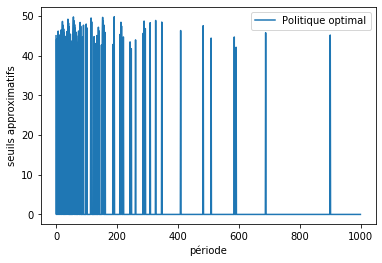

In [423]:
#affichage des seuils(politique optimale)
plt.plot(approx(N,x0,u,r,K,q)[2])
plt.legend(['Politique optimal'])
plt.ylabel('seuils approximatifs')
plt.xlabel('période')
plt.show()

## comparaison des deux algorithmes

In [424]:
from sklearn.metrics import mean_squared_error
erreur=[]
exacte=[J[0][0]]*50
for m in range(50):
    erreur.append(approx(N,x0,u,r,K,q)[1])

mean_squared_error(exacte, erreur)

C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: Ran

C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: Ran

C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\yohev\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned


3.1546029386653434

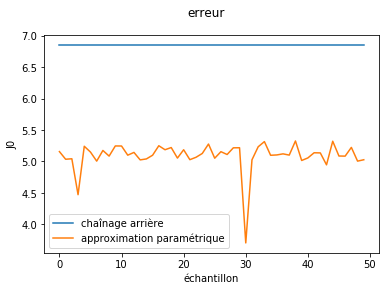

In [425]:
#illustration de l'erreur d'approximation par rapport au résultat obtenue par le chaînage arrière
plt.plot(exacte)
plt.plot(erreur)
plt.legend(['chaînage arrière','approximation paramétrique'])
plt.ylabel('J0')
plt.xlabel('échantillon')
plt.suptitle('erreur')
plt.show()